# Replication file for 'The Intertemporal Keynesian Cross'
### Part II: fiscal policy in the IKC environment (section 5)

Adrien Auclert, Matthew Rognlie, Ludwig Straub

April 2024

In [1]:
import numpy as np
import json

In [2]:
from base import calibration, fiscal, jacobian_manipulation as jac
from models import models_analytical, models_heterogeneous
from plotting import sec5_plots as plots

opts = {'texfig': True, 'savefig': True} # flags for plotting

## Preliminary: calculate M and A matrices for all models
First, we need to load the saved `params` dictionary from our calibration in `main_sec34.ipynb`.

In [3]:
with open('intermediates/solved_params.json', 'r') as f:
    params = json.load(f)

For analytical models, this data is enough to calculate the M and A matrices:

In [4]:
T = 500
r = calibration.r
Ms, As = models_analytical.MA_all(params, r, T)

For heterogeneous-agent models, we will load the household blocks and calculated the steady states, then calculate the matrices. This is almost immediate except for the HA-two model, where it may take 15-60 seconds:

In [5]:
hh_het, ss_het = models_heterogeneous.get_all(params)
for m in ss_het:
    J = hh_het[m].jacobian(ss_het[m], inputs=['Z'], outputs=['C', 'A'], T=T)
    Ms[m], As[m] = J['C', 'Z'], J['A', 'Z']

# Calculate fiscal multipliers

#### Calculating $\mathcal{M}$ (`curlyM`)
First, we need to calculate the $\mathcal{M}$, or `curlyM`, operator for each model. Recall that equation (16) states that the solution to the IKC is
$$
\mathcal{M} \equiv (\mathbf{K}(\mathbf{I}-\mathbf{M}))^{-1}\mathbf{K} = \mathbf{A}^{-1}\mathbf{K}
$$
To avoid problems arising from the truncation, we will directly use $\mathbf{A}$ rather than calculating $\mathbf{K}(\mathbf{I}-\mathbf{M})$. Alternative approaches to solve the IKC are described in `appendix_solution_methods.ipynb`, which closely parallels appendix A.7 of the paper.

In [6]:
K = jac.Kmat(r, T)
curlyMs = {m: np.linalg.solve(As[m], K) for m in As}

One annoying detail: note that as an infinite-dimensional object, $\mathbf{A}$ is actually not invertible for the RA and TA models, so that this formula does not directly apply for them. As observed in section 5 of the paper, this corresponds to multiplicity in the RA and TA models, which takes the form of a permanent level shift in $dY_t$. This multiplicity goes away once we make the additional assumption that $dY_t\rightarrow 0$ (assuming $dG_t,dT_t\rightarrow 0$).

In practice, we can select the $dY_t\rightarrow 0$ equilibrium by multiplying $\mathcal{M}$ on the left by an operator that subtracts the last entry (which should be zero) from all others. This is equivalent to subtracting the last row from all other rows.

In [7]:
curlyMs['RA'] -= curlyMs['RA'][-1]
curlyMs['TA'] -= curlyMs['TA'][-1]

#### Calculating fiscal multipliers for main exercise
Our main exercise will be an AR(1) shock to spending with persistence $\rho_G$, for various persistences $\rho_B$ of debt. We'll calculate the multipliers on impact, cumulatively, and also (though not in our graphs) over a 5-year horizon.

In [8]:
dG = calibration.rhoG ** np.arange(T)
NrhoB = 20
rhoBs = np.linspace(0, calibration.rhoB, NrhoB)
mult_impact, mult_5yr, mult_cumul = {}, {}, {}

First, let's calculate the implied tax plan $dT$ for each $\rho_B$.

In [9]:
dBs = [fiscal.Bplan(dG, rho_B) for rho_B in rhoBs]
dTs = [fiscal.Tplan(dG, dB, r) for dB in dBs]

Now, for each model, calculate $dY$ and multipliers for each $\rho_B$:

In [10]:
dYs = {}
for m in curlyMs:
    m_impact, m_5yr, m_cumul, dYs[m] = np.empty(NrhoB), np.empty(NrhoB), np.empty(NrhoB), {}
    
    # iterate over rhoBs and the associated dT plan
    for i, (rhoB, dT) in enumerate(zip(rhoBs, dTs)):
        # calculate dY using equation (16), store implied multipliers
        dYs[m][i] = curlyMs[m] @ (dG - Ms[m] @ dT) 
        m_impact[i], m_5yr[i], m_cumul[i] = fiscal.compute_multipliers(dYs[m][i], dG, r)

    mult_impact[m], mult_5yr[m], mult_cumul[m] = m_impact, m_5yr, m_cumul

#### Figure 5
Plotting the resulting fiscal multipliers:

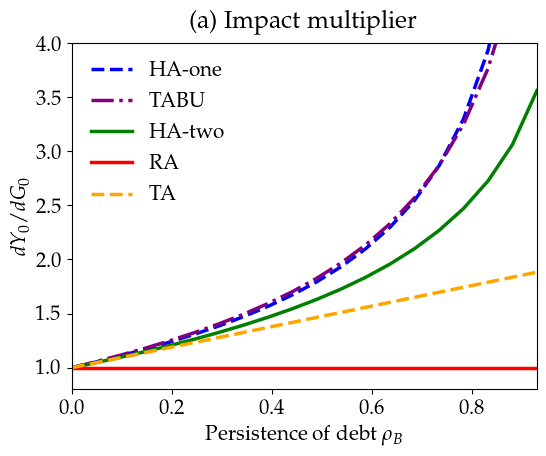

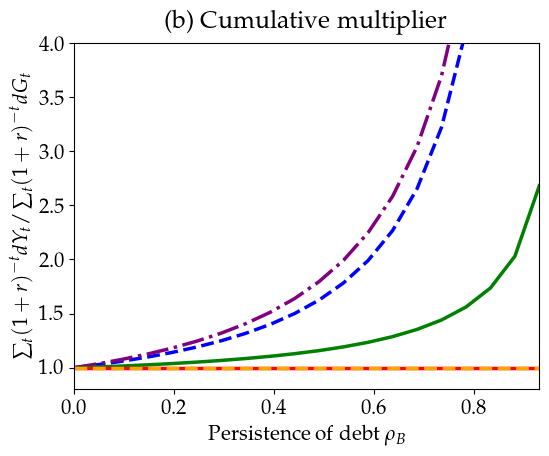

In [11]:
plots.figure5(rhoBs, mult_impact, mult_cumul, **opts)

#### Figure E.2
Now plotting multipliers for all models:

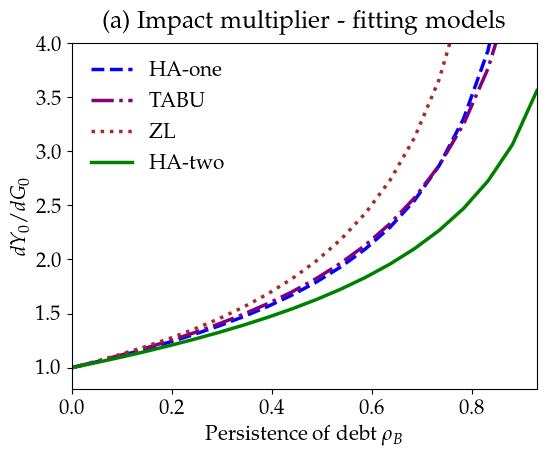

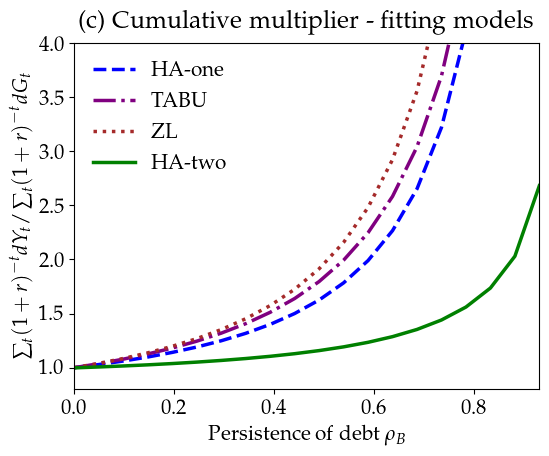

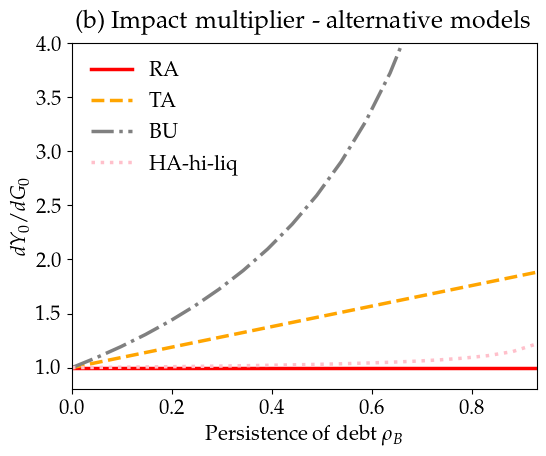

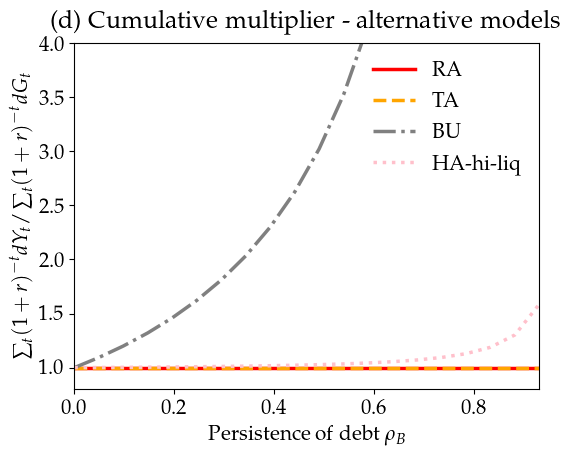

In [12]:
plots.figureE2(rhoBs, mult_impact, mult_cumul, **opts)

#### Table 4 (IKC environment part)

In [13]:
plots.table4(mult_impact, mult_cumul).round(1)

,RA,TA,TABU,HA-one,HA-two
BB impact,1.0,1.0,1.0,1.0,1.0
BB cumulative,1.0,1.0,1.0,1.0,1.0
DF impact,1.0,1.9,5.6,6.9,3.6
DF cumulative,1.0,1.0,15.5,16.6,2.7


### Testing analytical formulas
First, proposition 4 says that we can write
$$
d\mathbf{Y} = d\mathbf{G} + \mathcal{M}\cdot\mathbf{M}\cdot (d\mathbf{G}-d\mathbf{T}) \tag{30}
$$
We can easily test that this agrees with our results above, from equation (16), up to some numerical error caused by truncation of Jacobians. This error is extremely small except in the HA-two model—where it is still small, but the very high long-run persistence of spending out of the illiquid account leads to more error from truncation.

In [14]:
for m in curlyMs:
    for i, (rhoB, dT) in enumerate(zip(rhoBs, dTs)):
        dY = dG + curlyMs[m] @ (Ms[m] @ (dG - dT))    # equation (30), prop4
        assert np.allclose(dY[:100], dYs[m][i][:100], atol=(1E-3 if m == 'HA-two' else 1E-9))

Next, we have formulas characterizing $d\mathbf{Y}$ for each of the analytical models.

**RA model.** Proposition 5 states that the RA model has $d\mathbf{Y} = d\mathbf{G}$ regardless of persistence:

In [ ]:
assert all(np.allclose(dYs['RA'][i], dG) for i in range(NrhoB))

**TA model.** Proposition 6 states that the TA model has $d\mathbf{Y} = d\mathbf{G} + \frac{\mu}{1-\mu}(d\mathbf{G}-d\mathbf{T})$:

In [16]:
mu = params['TA']['mu']
assert all(np.allclose(dYs['TA'][i], dG + mu/(1-mu)*(dG - dTs[i])) for i in range(NrhoB))

**BU and TABU models.** Equation (31) in Proposition 7, defining the saver's MPC $m\equiv 1-\frac{\lambda}{1+r}$ for convenience, states that for a TABU model
$$
dY_t = dG_t + \frac{\mu}{1-\mu}(dG_t - dT_t) + (1+r)\frac{m}{1-\mu}\left(\lambda^{-1} - \beta(1+r)\right)\sum_{s=0}^\infty (\beta(1+r))^s dB_{t+s}
$$
Writing this as a function, we have:

In [17]:
def pdv_dB(dB, b):
    # recursively take pdv of future dB using discount factor b
    pdv = np.empty(len(dB))
    pdv[-1] = dB[-1]
    for t in reversed(range(T-1)):
        pdv[t] = b*pdv[t+1] + dB[t]
    return pdv

def dY_TABU(dG, dT, dB, r, beta, mu, lamb):
    m = 1 - lamb/(1+r) 
    return dG + mu/(1-mu)*(dG - dT) + (1+r)*m/(1-mu)*(1/lamb - beta*(1+r))*pdv_dB(dB, beta*(1+r))

Now testing for the BU case:

In [18]:
beta, mu, lamb = params['BU']['beta'], 0, params['BU']['lamb']
assert all(np.allclose(dY_TABU(dG, dT, dB, r, beta, mu, lamb), dYs['BU'][i])
                                    for i, (dT, dB) in enumerate(zip(dTs, dBs)))

Testing for the TABU case:

In [19]:
beta, mu, lamb = params['TABU']['beta'], params['TABU']['mu'], params['TABU']['lamb']
assert all(np.allclose(dY_TABU(dG, dT, dB, r, beta, mu, lamb), dYs['TABU'][i])
                                    for i, (dT, dB) in enumerate(zip(dTs, dBs)))

**ZL model.** Equation (A.110) in Proposition 11 states that for a ZL model,
$$
dY_t = dG_t + \frac{\mu}{1-\mu}(dG_t-dT_t) - \frac{1-\beta(1+r)}{1-\mu}dB_t + (1+r)\frac{1-\beta\lambda}{1-\mu}(\lambda^{-1}-1)\sum_{s=0}^\infty dB_{t+s}
$$

In [20]:
beta, mu, lamb = params['TABU']['beta'], params['TABU']['mu'], params['TABU']['lamb']
assert all(np.allclose(dYs['ZL'][i], dG + mu/(1-mu)*(dG-dTs[i]) - (1-beta*(1+r))/(1-mu)*dBs[i]
        + (1+r)*(1-beta*lamb)/(1-mu)*(1/lamb - 1)*pdv_dB(dBs[i], 1)) for i, (dT, dB) in enumerate(zip(dTs, dBs)))

## Testing the role of anticipation with cognitive discounting
Now we create Figure 6(a) and Figure E.5, obtaining cumulative multipliers for our set of similar models that fit the iMPC data (TABU, HA-one, HA-two) as we dampen expectations by adjusting the cognitive discount factor $\delta$.

First, for this exercise we set $\rho_B$ at a particular value, $\rho_G$, and then vary $\delta$:

In [21]:
rhoB = calibration.rhoG
dB = fiscal.Bplan(dG, rhoB)
dT = fiscal.Tplan(dG, dB, r)

Now, we calculate $\mathbf{M}$ and $\mathcal{M}$ as we vary $\delta$:

In [22]:
models = ['HA-one', 'TABU', 'HA-two']
deltas = np.linspace(0, 1, 20)
Ms_disc, curlyMs_disc = {}, {}
for m in models:
    Ms_disc[m], curlyMs_disc[m] = {}, {}
    for i, delta in enumerate(deltas):
        A, M = jac.cognitive_discounting(As[m], delta), jac.cognitive_discounting(Ms[m], delta)
        Ms_disc[m][i], curlyMs_disc[m][i] = M, np.linalg.solve(A, K)

#### Figure 6(a)

Then calculate cumulative multipliers for each model as we vary $\delta$:

In [23]:
mult_disc = {}
for m in models:
    mult_disc[m] = np.empty_like(deltas)
    for i, delta in enumerate(deltas):
        dY = curlyMs_disc[m][i] @ (dG - Ms_disc[m][i] @ dT)
        _, _, mult_disc[m][i] = fiscal.compute_multipliers(dY, dG, r)

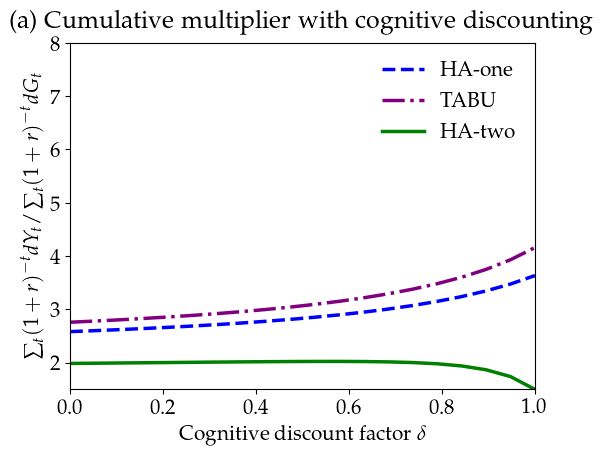

In [24]:
plots.figure6_E5(deltas, mult_disc,
               title='(a) Cumulative multiplier with cognitive discounting',
               xlabel=r'Cognitive discount factor $\delta$', id='6_a', **opts)

#### Figure E.2
We can also vary the multiplier $\mathcal{M}$, which applies to gross income, and the direct effect of taxes $\mathbf{M}d\mathbf{T}$ separately, applying cognitive discounting to one but not the other. This is in figure E.2.

In [25]:
mult_only_taxes, mult_only_income = {}, {}
for m in models:
    mult_only_taxes[m], mult_only_income[m] = np.empty_like(deltas), np.empty_like(deltas)
    for i, delta in enumerate(deltas):
        # only apply cognitive discounting to M matrix applied to taxes
        dY_only_taxes = curlyMs[m] @ (dG - Ms_disc[m][i] @ dT)

        # only apply cognitive discounting to curlyM multiplier matrix, amplifying income
        dY_only_income = curlyMs_disc[m][i] @ (dG - Ms[m] @ dT)

        _, _, mult_only_taxes[m][i] = fiscal.compute_multipliers(dY_only_taxes, dG, r)
        _, _, mult_only_income[m][i] = fiscal.compute_multipliers(dY_only_income, dG, r)

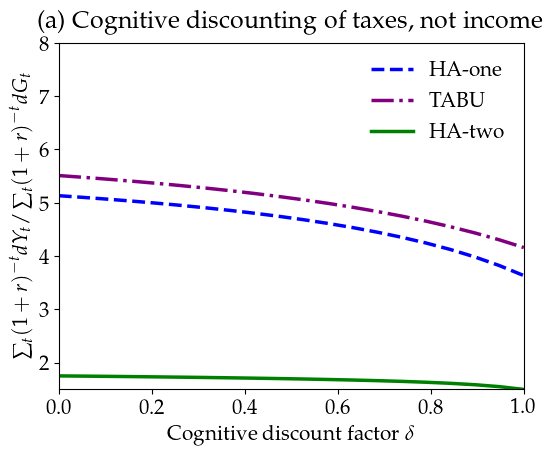

In [26]:
plots.figure6_E5(deltas, mult_only_taxes,
               title='(a) Cognitive discounting of taxes, not income',
               xlabel=r'Cognitive discount factor $\delta$', id='E5_a', **opts)

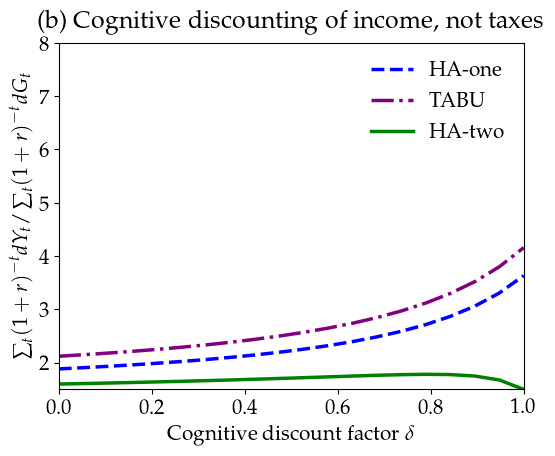

In [27]:
plots.figure6_E5(deltas, mult_only_income,
               title='(b) Cognitive discounting of income, not taxes',
               xlabel=r'Cognitive discount factor $\delta$', id='E5_b', **opts)

## Testing the role of tail behavior with truncation
Now we create Figure 6(b), obtaining cumulative multipliers for the same set of models as we "truncate" the $\mathbf{M}$ spending response past some distance $T_0$ from the main diagonal (scaling up the remaining iMPCs to enforce budget balance).

In [28]:
T0s = np.arange(10, 51, 2)
mult_trunc = {}
for m in models:
    mult_trunc[m] = np.empty(len(T0s))
    for i, T0 in enumerate(T0s):
        M, A = jac.truncate_M(Ms[m], T0, T0, r)
        dY = np.linalg.solve(A, K @ (dG - M @ dT))
        _, _, mult_trunc[m][i] = fiscal.compute_multipliers(dY, dG, r)

#### Figure 6(b)

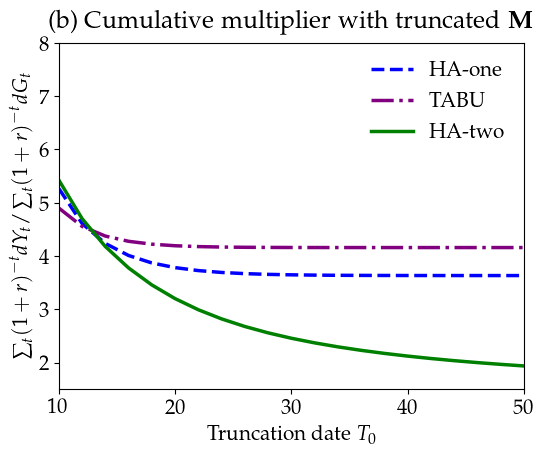

In [29]:
plots.figure6_E5(T0s, mult_trunc,
               title=r'(b) Cumulative multiplier with truncated $\mathbf{M}$',
               xlabel=r'Truncation date $T_0$', id='6_b', **opts)

# Alternative: Lump-sum taxation at the margin

Load a slightly modified version of the HA-one model that has a lump-sum transfer (calibrated to zero in steady state) built in.

In [30]:
ha_one_lumpsum, ss_lumpsum = models_heterogeneous.get_ha_one_lumpsum(params['HA-one'])

Obtain $\mathbf{M}^T$ matrix with respect to this transfer.

In [31]:
M_lumpsum = ha_one_lumpsum.jacobian(ss_lumpsum, inputs=['Tr'], outputs=['C', 'A'], T=T)['C', 'Tr']

What is "partial equilibrium" output effect $(\mathbf{I} - \mathbf{M})d\mathbf{G}$ of a balanced-budget spending shock for our benchmark case, vs. the effect $(\mathbf{I} - \mathbf{M}^T)d\mathbf{G}$ here? The difference is the "redistribution" effect $(\mathbf{M}^T - \mathbf{M})\mathbf{G}$.

In [32]:
dY_pe_bench = dG - Ms['HA-one'] @ dG
dY_pe_lumpsum = dG - M_lumpsum @ dG
dY_pe_redist = dY_pe_lumpsum - dY_pe_bench

Now, what about the GE effects?

In [33]:
dY_ge_bench = curlyMs['HA-one'] @ (dG - Ms['HA-one'] @ dG)
dY_ge_lumpsum = curlyMs['HA-one'] @ (dG - M_lumpsum @ dG)
dY_ge_redist = dY_ge_lumpsum - dY_ge_bench

#### Figure E.1

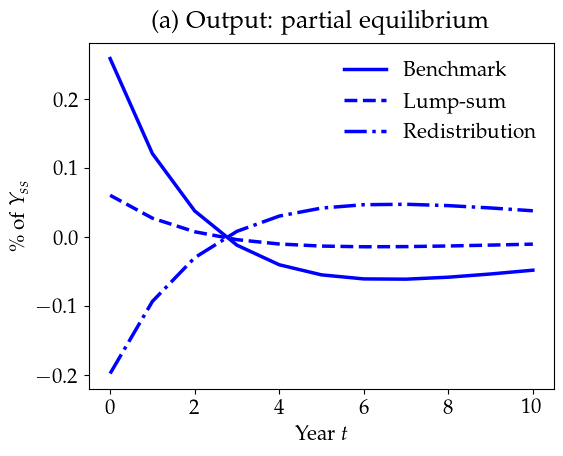

In [34]:
plots.figureE1(dY_pe_bench, dY_pe_lumpsum, dY_pe_redist,
               title='(a) Output: partial equilibrium', id='a', **opts)

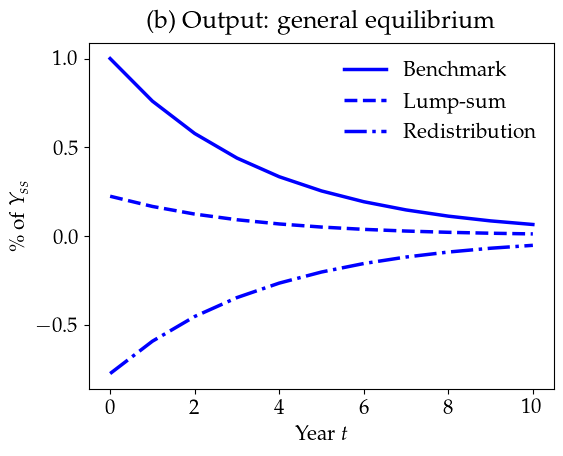

In [35]:
plots.figureE1(dY_ge_bench, dY_ge_lumpsum, dY_ge_redist, yticks=[-0.5, 0, 0.5, 1],
               title='(b) Output: general equilibrium', id='b', **opts)

# PE to GE: fiscal policy, monetary policy, and deleveraging


Need to load a slightly modified version of the HA-one household block:

In [36]:
ha_one_con, ss_con = models_heterogeneous.get_ha_one_con(params['HA-one'])

Then, in addition to our original $\mathbf{M}$ matrix, which will be unchanged, we need the $\mathbf{M}^r$ matrix in response to real interest rates, and also the response to a "deleveraging" shock to the borrowing constraint.

In [37]:
jacs = ha_one_con.jacobian(ss_con, inputs=['r', 'a_con'], outputs=['C'], T=T)
Mr, Mcon = jacs['C', 'r'], jacs['C', 'a_con']
curlyM, M = curlyMs['HA-one'], Ms['HA-one']

**Deficit-financed spending shock.**
The parameters for this shock are a bit different from our previous exercise, with $\rho_G=0.8$ and $\rho_B=0.5$.

In [38]:
dG = 0.8**np.arange(T)
dB = fiscal.Bplan(dG, 0.5)
dT = fiscal.Tplan(dG, dB, r)

dY_pe_deficit = dG - M @ dT
dY_ge_deficit = curlyM @ dY_pe_deficit

**Monetary policy shock.** This shock is $dr_t=0.8^t$, but we need to translate to the ex-post timing for $r$ used by our blocks, in which the ex-post interest rate at date 0 is unchanged:

In [39]:
dr = np.zeros(T)
dr[1:] = 0.8**np.arange(T-1)

We assume that the government follows a balanced-budget rule, immediately raising taxes to pay interest on the debt:

In [40]:
dT = ss_con['A']*dr

Now we can solve for the PE and GE effects:

In [41]:
dY_pe_monetary = Mr @ dr - M @ dT
dY_ge_monetary = curlyM @ dY_pe_monetary

**Deleveraging shock.**

In [42]:
dacon = 0.8**np.arange(T)
dY_pe_delev = Mcon @ dacon
dY_ge_delev = curlyM @ dY_pe_delev

#### Figure A.2

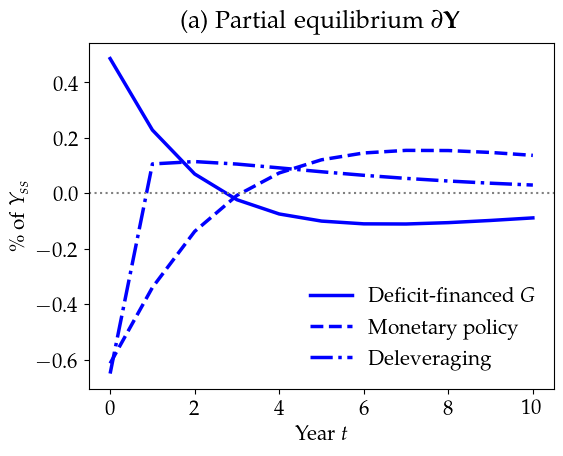

In [43]:
plots.figureA2(dY_pe_deficit, dY_pe_monetary, dY_pe_delev,
               title=r'(a) Partial equilibrium $\partial \mathbf{Y}$', id='a', **opts) 

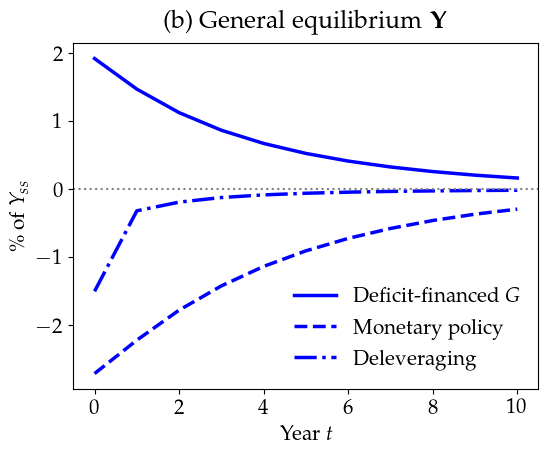

In [44]:
plots.figureA2(dY_ge_deficit, dY_ge_monetary, dY_ge_delev,
               title=r'(b) General equilibrium $\mathbf{Y}$', id='b', **opts)